In [1]:
##################################################################################################################
############################## PRACTICA DESPLIEGUE ALGORITMOS: Jordi Ortega - IA2 ################################
##################################################################################################################

# 0. Ejercicio 1. Clasificación con Scikit-learn y MLflow

# 1. Venv -> Creamos un entorno específico para el modulo de 'despliegue de algoritmos'
# 2. Exploración de Datos -> Trabajo realizado en el módulo de NLP. Para más detalle referirse a: https://github.com/JordiOrtegaBI/Playground/tree/master/nlp
# 3. Preprocesamiento de Texto -> Trabajo realizado en el módulo de NLP. Para más detalle referirse a: https://github.com/JordiOrtegaBI/Playground/tree/master/nlp
# 4. Dataset -> Cargamos el dataset
# 5. Entrenamiento del Modelo -> Dividimos el dataset y entrenamos el modelo
# 6. Evaluación del Modelo -> Obtenemos las principales métricas y dibujamos una matriz de confusión
# 7. Registro de Métricas con MLflow -> Usamos MLflow para testear diverdas métricas mediante diversos paramétros
# 8. Conclusiones y pantallazos de MLflow ui

In [2]:
##################################################################################################################
############################## VENV ##############################################################################
##################################################################################################################

In [3]:
# Desde cmd: Creamos un entorno virtual específico, lo activamos, instalamos las librerías del requirements y añadimos ipykernel para poder trabajar con ipynb.
# python -m venv venv
# venv\Scripts\activate
# pip install -r requirements.txt
# pip install ipykernel

In [4]:
##################################################################################################################
############################## DATASET ###########################################################################
##################################################################################################################

In [7]:
import pandas as pd

# Este dataset viene preprocesado, balanceado y tokenizado (trabajo realizado en un modulo anterior)
df_unigram = pd.read_csv('df_sports_outdoors_unigram.csv')
df_unigram.head(5)

,Unnamed: 0,sentiment,title,review,sentiment_label,review_clean
0,0,5.0,"Greatly impressed, I recommend these","Ordered a few bags, put some in mine and my c...",0,"['ordered', 'bag', 'put', 'mine', 'child', 'gl..."
1,1,5.0,Great Lures,Nice quality lures heavy duty,0,"['nice', 'quality', 'heavy', 'duty']"
2,2,5.0,Perfect for what I needed,Lost mine in a move. Perfect for what I needed.,0,"['lost', 'mine', 'move', 'perfect', 'needed']"
3,3,5.0,Great Product,Great quality. Adjustable from 22lbs-88lbs of...,0,"['great', 'quality', 'adjustable', 'tension']"
4,4,5.0,Great box,This mini Tackle box comes with so many fishin...,0,"['box', 'come', 'many', 'fishing', 'make', 'fi..."


In [11]:
##################################################################################################################
############################## ENTRENAMIENTO DEL MODELO ##########################################################
##################################################################################################################

In [12]:
from sklearn.model_selection import train_test_split

# Determinamos los valores de X e y (siendo X los tokens resultantes del preprocesado)
X = df_unigram['review_clean']
y = df_unigram['sentiment_label']

# Dividimos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,  stratify=y)

In [13]:
print(X_train.iloc[0])

['people', 'without', 'hand', 'strength']


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Transformamos el texto en representaciones númericas y limitamos a 5K el vocabulario (palabras más frecuentes). El vocabulario quedará por debajo de este límite.
def extract_BoW_features(words_train, words_test, vocabulary_size=5000):
    vectorizer = CountVectorizer(max_features=vocabulary_size, analyzer='word', tokenizer=None)

    # Aprendemos el vocabulario y lo aplicamos en test
    features_train = vectorizer.fit_transform(words_train).toarray()
    features_test = vectorizer.transform(words_test).toarray()

    # Guardamos el vocabulario
    vocabulary = vectorizer.vocabulary_

    return features_train, features_test, vocabulary

# Extraemos las características de Bag of Words
features_train, features_test, vocabulary = extract_BoW_features(X_train, X_test)

In [15]:
print("Tamaño del vocabulario:", len(vocabulary))

Tamaño del vocabulario: 998


In [16]:
# Vocabulario aprendido por el vectorizador
print("Vocabulario:", vocabulary)

# Primer vector BoW
print("Vector BoW para la primera reseña:", features_train[0])

# Comparamos con los tokens originales
print("Tokens de la primera reseña:", X_train.iloc[0])

# Accedemos a la palabra 'without' para comprobar que el bector BoW lo recoge correctamente
print("Valor en la posición 975 del vector BoW para la primera reseña:", features_train[0][975])

Vocabulario: {'people': np.int64(596), 'without': np.int64(975), 'hand': np.int64(361), 'strength': np.int64(823), 'price': np.int64(638), 'wrong': np.int64(989), 'need': np.int64(543), 'whistle': np.int64(965), 'use': np.int64(920), 'group': np.int64(354), 'thing': np.int64(863), 'hear': np.int64(370), 'item': np.int64(429), 'soon': np.int64(793), 'put': np.int64(658), 'roller': np.int64(708), 'worked': np.int64(981), 'pretty': np.int64(637), 'well': np.int64(960), 'far': np.int64(281), 'slip': np.int64(775), 'mat': np.int64(506), 'slide': np.int64(773), 'bit': np.int64(86), 'really': np.int64(675), 'big': np.int64(83), 'enough': np.int64(248), 'knee': np.int64(443), 'like': np.int64(471), 'doe': np.int64(221), 'metal': np.int64(516), 'part': np.int64(592), 'product': np.int64(643), 'think': np.int64(864), 'great': np.int64(350), 'heavy': np.int64(374), 'purpose': np.int64(656), 'fine': np.int64(296), 'real': np.int64(674), 'cheap': np.int64(139), 'one': np.int64(567), 'returned': np.

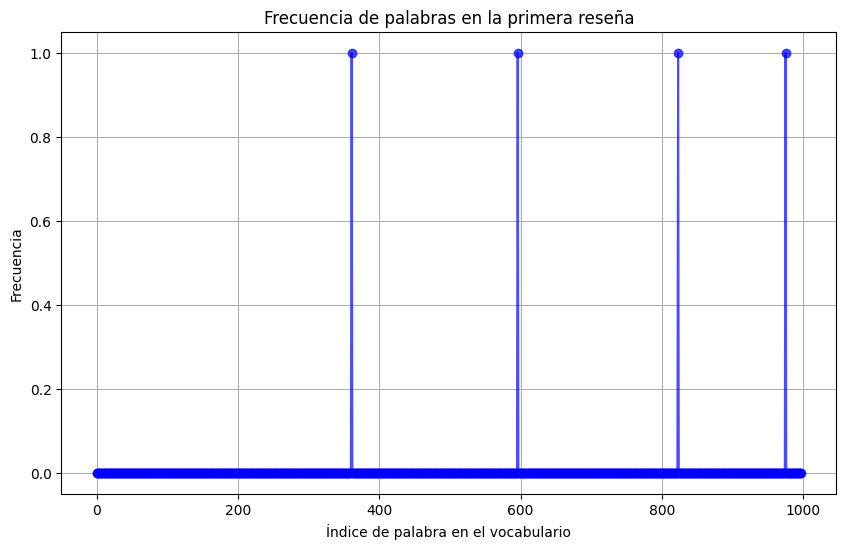

In [17]:
import matplotlib.pyplot as plt

# Graficamos la frecuencia de las palabras para la muestra de la reseña 1 en features_train
plt.figure(figsize=(10, 6))
plt.plot(features_train[0, :], marker='o', linestyle='-', color='b', alpha=0.7)
plt.xlabel('Índice de palabra en el vocabulario')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de palabras en la primera reseña')
plt.grid(True)
plt.show()

In [18]:
# Vamos a normalizar para asegurar que las características tengan el mismo rango lo que ayudará a los algoritmos
import sklearn.preprocessing as pr

features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

In [19]:
print(f"X_train shape: {features_train.shape}")
print(f"X_test shape: {features_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3908, 998)
X_test shape: (978, 998)
y_train shape: (3908,)
y_test shape: (978,)


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 16
learning_rate=0.05
max_depth=4

def classify_gboost(features_train, features_test, y_train, y_test,n_estimators,learning_rate,max_depth):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

    # Entrenamiento del modelo con los datos numéricos
    clf.fit(features_train, y_train)

    # Evaluación de precisión (accuracy) con los datos numéricos
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(features_train, y_train),
            clf.score(features_test, y_test)))

    return clf

# Entrenamos el modelo
clf2 = classify_gboost(features_train, features_test, y_train, y_test,n_estimators,learning_rate,max_depth)

[GradientBoostingClassifier] Accuracy: train = 0.7364380757420675, test = 0.7177914110429447


In [21]:
##################################################################################################################
############################## EVALUACIÓN DEL MODELO #############################################################
##################################################################################################################

In [22]:
# Métricas del modelo
# - precision_score: Mide la proporción de verdaderos positivos sobre todos los ejemplos clasificados como positivos (es decir, cuántos de los elementos que el modelo clasificó como positivos realmente lo son).
# - recall_score: Mide la proporción de verdaderos positivos sobre todos los ejemplos que realmente son positivos (es decir, cuántos de los ejemplos positivos el modelo fue capaz de identificar).
# - f1_score: Es la media armónica de la precisión y el recall

from sklearn.metrics import precision_score, recall_score, f1_score

# Hacemos predicciones
y_pred_train = clf2.predict(features_train)
y_pred_test = clf2.predict(features_test)

# Calculamos las métricas de evaluación para el conjunto de entrenamiento
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

# Calculamos las métricas de evaluación para el conjunto de prueba
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"--- Train Set Metrics ---")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")

print(f"\n--- Test Set Metrics ---")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")

# Nota la predicción en train se realiza sólo como referencia

--- Train Set Metrics ---
Precision: 0.6809
Recall: 0.7856
F1 Score: 0.7295

--- Test Set Metrics ---
Precision: 0.6647
Recall: 0.7579
F1 Score: 0.7082


In [23]:
# Verdadero Positivo (True Positive, TP):
# Son los casos en los que el modelo predice que la reseña es negativa (sentiment_label = 1), y realmente es negativa (sentiment_label = 1).

# Verdadero Negativo (True Negative, TN):
# Son los casos en los que el modelo predice que la reseña es positiva (sentiment_label = 0), y realmente es positiva (sentiment_label = 0).

# Falso Positivo (False Positive, FP):
# Son los casos en los que el modelo predice que la reseña es negativa (sentiment_label = 1), pero en realidad es positiva (sentiment_label = 0).

# Falso Negativo (False Negative, FN):
# Son los casos en los que el modelo predice que la reseña es positiva (sentiment_label = 0), pero en realidad es negativa (sentiment_label = 1).

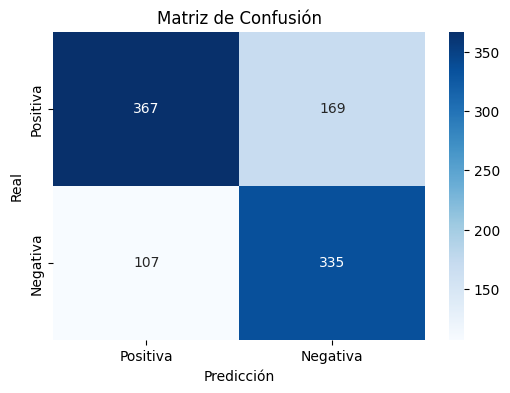

Matriz de Confusión:
[[367 169]
 [107 335]]


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones del modelo
y_pred = clf2.predict(features_test)

# Generamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positiva", "Negativa"], yticklabels=["Positiva", "Negativa"])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


print("Matriz de Confusión:")
print(cm)

In [25]:
# Conclusiones del modelo:
# 1. El modelo obtiene un buen rendimiento en general (equilibrio entre precisión y recall)
# 2. El modelo tiene capacidad para identificar casos positivos (recall)
# 3. El modelo tiene una precisión superior en train que en test ("falsas alarmas")
# 4. Las métricas estan ajustadas en train y test así que descartamos sobreajuste
# 5. Deberíamos seguir iterando con el modelo y sus hiperparámetros para mejorar el rendimiento
# 6. Podríamos aumentar el dataset usado en los modelos

In [26]:
##################################################################################################################
############################## REGISTRO MÉTRICAS MLFLOW ##########################################################
##################################################################################################################

In [24]:
clf2.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'log_loss',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 16,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [25]:
print(type(features_train))

<class 'numpy.ndarray'>


In [27]:
import mlflow
import numpy as np


# Testeamos de forma manual diversos parametros y métricas
input_example = np.array([features_train[0]])

mlflow.set_experiment('Amazon reviews')
with mlflow.start_run(run_name='practica despliegue v5'):
   
    mlflow.log_param('n_estimators', 32)
    mlflow.log_param('learning_rate', 1)
    mlflow.log_param('max_depth', 12)
    mlflow.log_param('random_state', 42)

    mlflow.log_metric('precision_train', precision_train)
    mlflow.log_metric('recall_train', recall_train)
    mlflow.log_metric('f1_train', f1_train)
    mlflow.log_metric('precision_test', precision_test)
    mlflow.log_metric('recall_test', recall_test)
    mlflow.log_metric('f1_test', f1_test)

    # Guardamos el modelo
    mlflow.sklearn.log_model(clf2, "xgboost", input_example=input_example)

c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/01/01 22:12:00 INFO mlflow.models.model: Found the following environment variables used during model inference: [SENDGRID_API_KEY]. Please check if you need to set them when deploying the model. To disable this message, set environment variable `MLFLOW_RECORD_ENV_VARS_IN_MODEL_LOGGING` to `false`.


In [30]:
!mlflow ui

^C


In [29]:
# Montamos el loop y definimos listas de valores para los parámetros
input_example = np.array([features_train[0]])

n_estimators_list = [2, 10, 32]
learning_rate_list= [0.1,0.5,1]
max_depth_list=[1,5,10]

mlflow.set_experiment("practica Amazon reviews loop")

for n in n_estimators_list:
    for lr in learning_rate_list:
        for depth in max_depth_list:
            with mlflow.start_run(run_name=f"n_estimators={n}_lr={lr}_max_depth={depth}") as run:       
                clf2 = classify_gboost(
                    features_train, features_test, y_train, y_test,
                    n,lr,depth
                )

                # Calculamos métricas
                y_pred_train = clf2.predict(features_train)
                y_pred_test = clf2.predict(features_test)
                
                precision_train = precision_score(y_train, y_pred_train, average='weighted')
                recall_train = recall_score(y_train, y_pred_train, average='weighted')
                f1_train = f1_score(y_train, y_pred_train, average='weighted')
                
                precision_test = precision_score(y_test, y_pred_test, average='weighted')
                recall_test = recall_score(y_test, y_pred_test, average='weighted')
                f1_test = f1_score(y_test, y_pred_test, average='weighted')

                # Registramos parámetros en MLflow
                mlflow.log_param("n_estimators", n)
                mlflow.log_param("lr", lr)
                mlflow.log_param("max_depth", depth)

                # Registramos métricas en MLflow
                mlflow.log_metric("precision_train", precision_train)
                mlflow.log_metric("recall_train", recall_train)
                mlflow.log_metric("f1_train", f1_train)

                mlflow.log_metric("precision_test", precision_test)
                mlflow.log_metric("recall_test", recall_test)
                mlflow.log_metric("f1_test", f1_test)

                # Guardamos el modelo
                mlflow.sklearn.log_model(clf2, "xgboost", input_example=input_example)


2025/01/01 22:24:30 INFO mlflow.tracking.fluent: Experiment with name 'practica Amazon reviews loop' does not exist. Creating a new experiment.


[GradientBoostingClassifier] Accuracy: train = 0.5475946775844421, test = 0.5480572597137015


c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[GradientBoostingClassifier] Accuracy: train = 0.5562947799385876, test = 0.5480572597137015


[GradientBoostingClassifier] Accuracy: train = 0.5928863868986693, test = 0.549079754601227


[GradientBoostingClassifier] Accuracy: train = 0.5475946775844421, test = 0.5480572597137015


c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[GradientBoostingClassifier] Accuracy: train = 0.7290174002047083, test = 0.712678936605317


[GradientBoostingClassifier] Accuracy: train = 0.8111566018423746, test = 0.7249488752556237


[GradientBoostingClassifier] Accuracy: train = 0.5946775844421699, test = 0.6022494887525562


[GradientBoostingClassifier] Accuracy: train = 0.7374616171954964, test = 0.7229038854805726


[GradientBoostingClassifier] Accuracy: train = 0.8055271238485159, test = 0.7300613496932515


[GradientBoostingClassifier] Accuracy: train = 0.5475946775844421, test = 0.5480572597137015


c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\JordiOrtega\023.keepcoding\DespliegueAlgoritmos\app\practica\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[GradientBoostingClassifier] Accuracy: train = 0.7587001023541453, test = 0.7167689161554193


[GradientBoostingClassifier] Accuracy: train = 0.8334186284544524, test = 0.7229038854805726


[GradientBoostingClassifier] Accuracy: train = 0.7070112589559877, test = 0.7137014314928425


[GradientBoostingClassifier] Accuracy: train = 0.8262538382804504, test = 0.7361963190184049


[GradientBoostingClassifier] Accuracy: train = 0.9201637666325486, test = 0.7433537832310838


[GradientBoostingClassifier] Accuracy: train = 0.7190378710337769, test = 0.7157464212678937


[GradientBoostingClassifier] Accuracy: train = 0.8308597748208802, test = 0.7382413087934561


[GradientBoostingClassifier] Accuracy: train = 0.9091606960081884, test = 0.7361963190184049


[GradientBoostingClassifier] Accuracy: train = 0.7082906857727738, test = 0.7065439672801636


[GradientBoostingClassifier] Accuracy: train = 0.8147389969293757, test = 0.7392638036809815


[GradientBoostingClassifier] Accuracy: train = 0.9035312180143296, test = 0.7535787321063395


[GradientBoostingClassifier] Accuracy: train = 0.7617707267144319, test = 0.7392638036809815


[GradientBoostingClassifier] Accuracy: train = 0.9101842374616171, test = 0.7668711656441718


[GradientBoostingClassifier] Accuracy: train = 0.9895087001023541, test = 0.7576687116564417


[GradientBoostingClassifier] Accuracy: train = 0.7781473899692938, test = 0.7494887525562373


[GradientBoostingClassifier] Accuracy: train = 0.9216990788126919, test = 0.7259713701431493


[GradientBoostingClassifier] Accuracy: train = 0.9948822927328557, test = 0.7321063394683026


In [ ]:
##################################################################################################################
############################## CONCLUSIONES ######################################################################
##################################################################################################################

In [ ]:
# Escoger el mejor modelo dependerá de las exigencias de negocio.
# Si estuviéramos ante un problema de diagnóstico médico tal vez interesaría seleccionar el de mejor recall y ante un problema de fraude tal vez el de mejor precisión.
# Teniendo un objetivo puramente académico seleccionaremos el modelo n_estimators=32_lr=1_max_depth=1 por ser un modelo con una precisión correcta y que generaliza bien.

# Se adjuntan pantallazos de MLflow ui:
# practica_mlflow_comparacion.png
# practica_mlflow_modelo_generaliza.png
# practica_mlflow_registro_modelo.png
# practica_mlflow_artifacts_run_predictions.png
# practica_mlflow_script.png